In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stable-diffusion-image-to-prompts/sample_submission.csv
/kaggle/input/stable-diffusion-image-to-prompts/prompts.csv
/kaggle/input/stable-diffusion-image-to-prompts/images/f27825b2c.png
/kaggle/input/stable-diffusion-image-to-prompts/images/92e911621.png
/kaggle/input/stable-diffusion-image-to-prompts/images/a4e1c55a9.png
/kaggle/input/stable-diffusion-image-to-prompts/images/20057f34d.png
/kaggle/input/stable-diffusion-image-to-prompts/images/d8edf2e40.png
/kaggle/input/stable-diffusion-image-to-prompts/images/227ef0887.png
/kaggle/input/stable-diffusion-image-to-prompts/images/c98f79f71.png


# 1. Showing/plotting the sample data

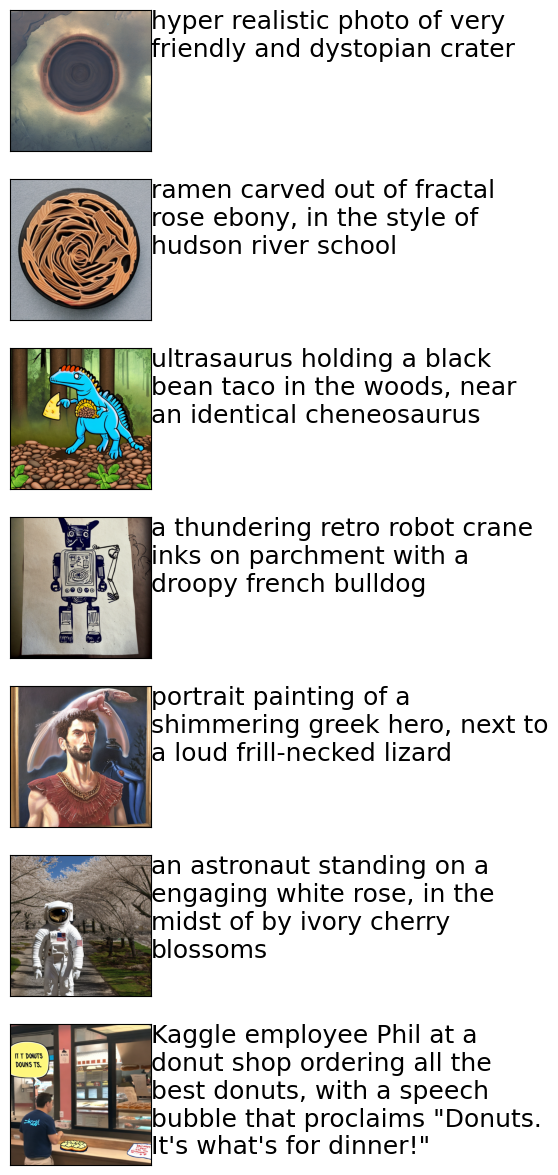

In [2]:
train_data = pd.read_csv("/kaggle/input/stable-diffusion-image-to-prompts/prompts.csv")
import pylab as plt
import matplotlib.image as mpimg
from PIL import Image
import textwrap

img_li = [mpimg.imread('/kaggle/input/stable-diffusion-image-to-prompts/images/'+imgId+'.png') for imgId in train_data['imgId']]
prompt_li = [prompt for prompt in train_data['prompt']]

def image_grid(prompts, imgs, rows, cols):
    assert len(imgs) == rows*cols
    Figure=plt.figure(figsize=(18,15))
    for idx,(img,prompt) in enumerate(zip(imgs,prompts)):
    
        ax=Figure.add_subplot(cols,rows,idx+1)
        ax.imshow(img)
        ax.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
        text= '\n'.join(textwrap.wrap(prompt,30))
        ax.annotate(text,xycoords='axes fraction',ha='left',va='top',xy=(1,1),wrap=True,fontsize=18)
    
image_grid(prompt_li, img_li, 1, 7)

# 2. data generation

## 2.1 Diffuser Image generator
ref to https://www.kaggle.com/code/mvvppp/sd2-gpt2-prompt-image-gen-dataset-creation
https://www.kaggle.com/code/andradaolteanu/img2text-image-generator-using-diffusers

In [3]:
!pip install transformers diffusers
from pathlib import Path
import tqdm

import torch
import pandas as pd
import numpy as np
from diffusers import StableDiffusionPipeline
#from transformers import pipeline, set_seed
#import matplotlib.pyplot as plt

from kaggle_secrets import UserSecretsClient

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 10.0 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [4]:
class CFG:
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    #seed = 42
    #generator = torch.Generator(device).manual_seed(seed)
    #image_gen_steps = 35
    image_gen_model_id = "stabilityai/stable-diffusion-2"
    #image_gen_size = (512, 512)
    #image_gen_guidance_scale = 9
    prompt_gen_model_id = "gpt2"
    #prompt_dataset_size = 6
    #prompt_max_length = 12
    
image_gen_model = StableDiffusionPipeline.from_pretrained(
    CFG.image_gen_model_id, 
    torch_dtype=torch.float16,
)
image_gen_model = image_gen_model.to(CFG.device)
print('Using device: ',CFG.device)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/transformers/models/clip/feature_extraction_clip.py:31: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  FutureWarning,


Using device:  cuda:0


### simple test

  0%|          | 0/50 [00:00<?, ?it/s]

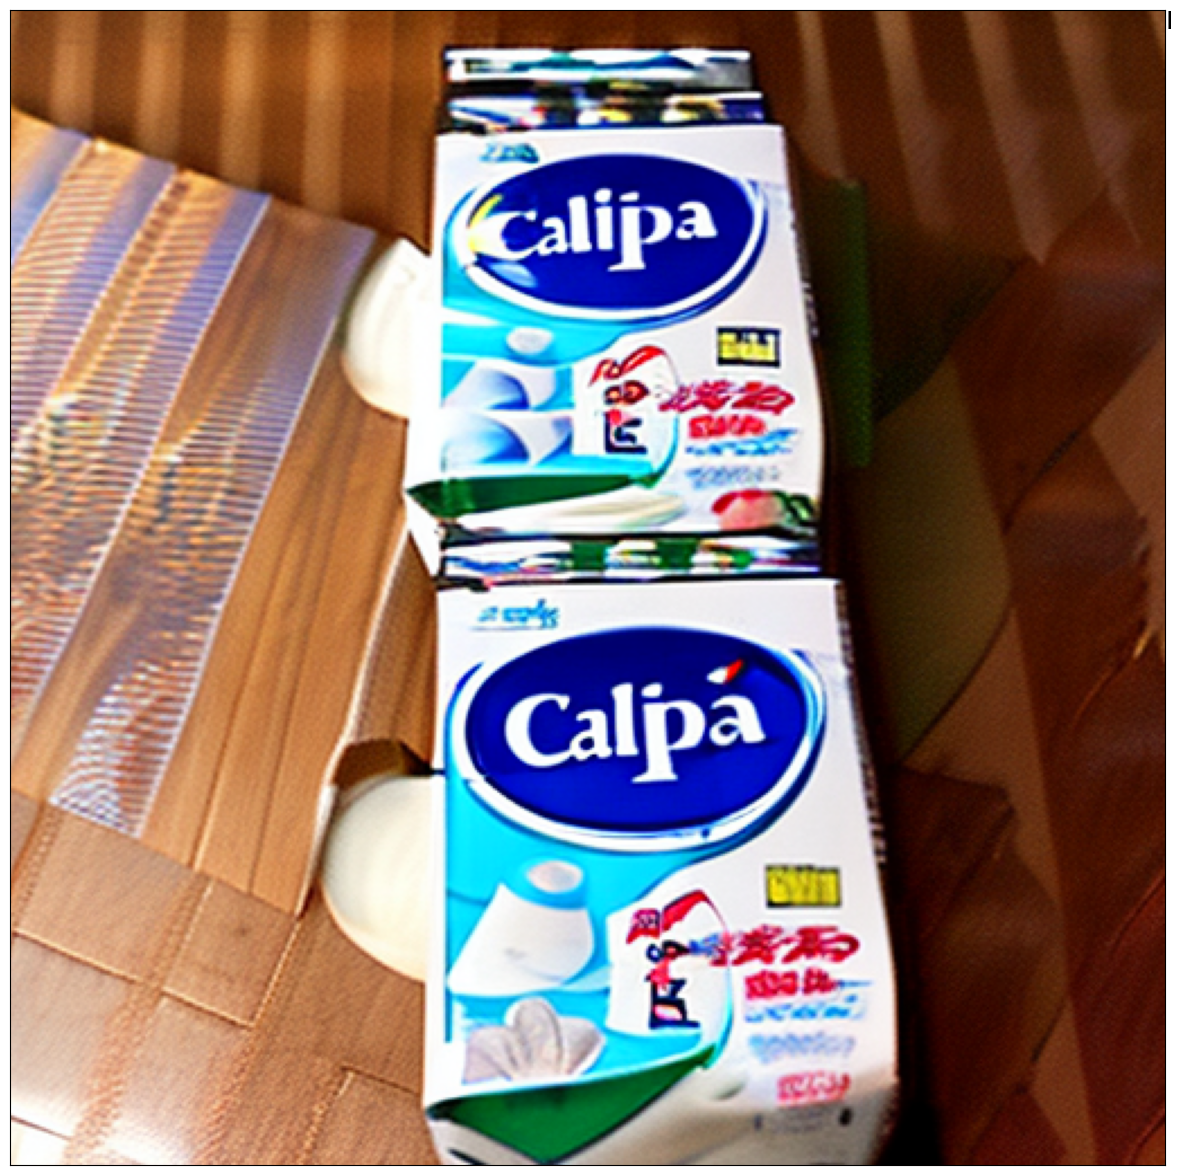

In [5]:
prompt = "I like Calpis"
imgs = image_gen_model(prompt,width=512,height=512).images
image_grid(prompt, imgs, rows=1, cols=1)

## 2.2 text generator
ref to https://www.kaggle.com/code/leonidkulyk/magicpromt-1m-prompts-generation-pipeline

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers.pipelines.text_generation import TextGenerationPipeline

class CFG:
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    magic_promt_hf_repo = "Gustavosta/MagicPrompt-Stable-Diffusion"
    pipeline_task = "text-generation"
    
tokenizer = AutoTokenizer.from_pretrained(CFG.magic_promt_hf_repo)
model = AutoModelForCausalLM.from_pretrained(CFG.magic_promt_hf_repo)
model.to(CFG.device)
generation_pipe = pipeline(CFG.pipeline_task, model=model, tokenizer=tokenizer)

## 2.3 Testing data generator

/opt/conda/lib/python3.7/site-packages/transformers/generation/utils.py:1187: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  "You have modified the pretrained model configuration to control generation. This is a"
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
/opt/conda/lib/python3.7/site-packages/transformers/generation/utils.py:1278: UserWarning: Neither `m

  0%|          | 0/50 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


  0%|          | 0/50 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


  0%|          | 0/50 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


  0%|          | 0/50 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


  0%|          | 0/50 [00:00<?, ?it/s]

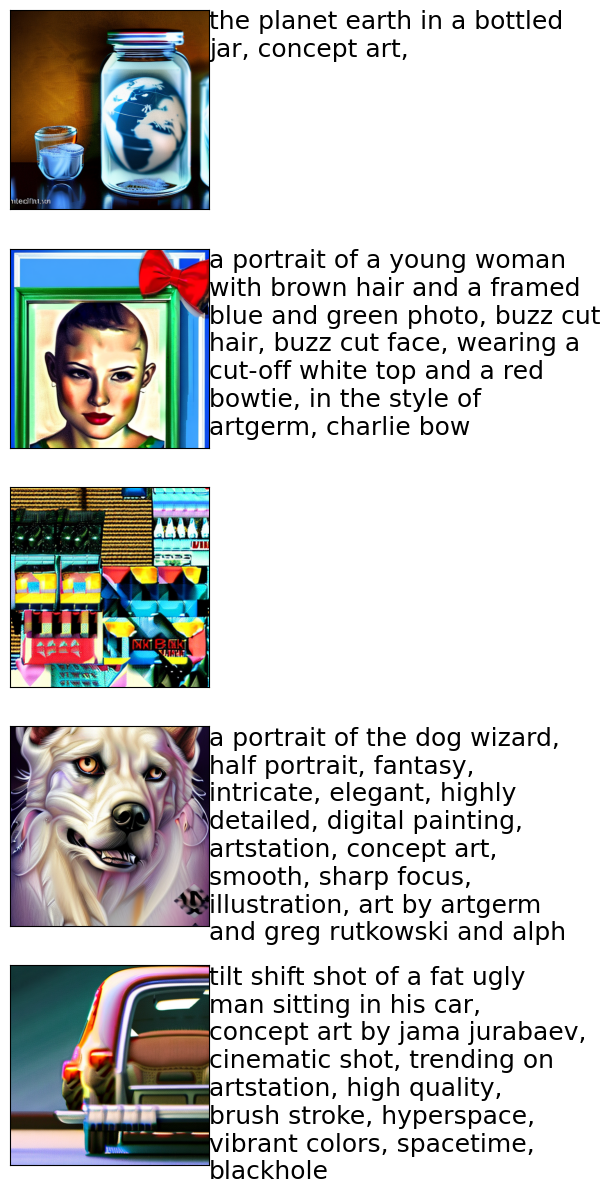

In [7]:
number=5
imgs = []
prompts = []
for i in np.arange(number):
    prompt = generation_pipe("")[0]['generated_text']
    prompts.append(prompt)
    img = image_gen_model(prompt,width=512,height=512).images
    imgs.append(img[0])
image_grid(prompts, imgs, rows=1, cols=number)